<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->


# Image similarity search with InfoGAN

This notebook shows how to implement an InfoGAN based on Gluon. InfoGAN is an extension of GANs, where the generator input is split in 2 parts: random noise and a latent code (see [InfoGAN Paper](https://arxiv.org/pdf/1606.03657.pdf)).
The codes are made meaningful by maximizing the mutual information between code and generator output. InfoGAN learns a disentangled representation in a completely unsupervised manner. It can be used for many applications such as image similarity search. This notebook uses the DCGAN example and extends it to create an InfoGAN.

In [1]:
from __future__ import print_function
from datetime import datetime
import logging
import multiprocessing
import os
import sys
import tarfile
import time

import numpy as onp
from matplotlib import pyplot as plt
import mxnet as mx
from mxnet import gluon
from mxnet import np, npx
from mxnet.gluon import nn, utils
from mxnet import autograd


The latent code vector can contain several variables, which can be categorical and/or continuous. We set `n_continuous` to 2 and `n_categories` to 10.

In [2]:
batch_size   = 64
z_dim        = 100
n_continuous = 2
n_categories = 10
device = mx.gpu() if mx.device.num_gpus() else mx.cpu()

Some functions to load and normalize images.

In [3]:
lfw_url = 'http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz'
data_path = 'lfw_dataset'
if not os.path.exists(data_path):
    os.makedirs(data_path)
    data_file = utils.download(lfw_url)
    with tarfile.open(data_file) as tar:
        tar.extractall(path=data_path)


In [4]:
def transform(data, width=64, height=64):
    data = mx.image.imresize(data, width, height)
    data = np.transpose(data, (2,0,1))
    data = data.astype(onp.float32)/127.5 - 1
    if data.shape[0] == 1:
        data = np.tile(data, (3, 1, 1))
    return data.reshape((1,) + data.shape)

In [5]:
def get_files(data_dir):
    images    = []
    filenames = []
    for path, _, fnames in os.walk(data_dir):
        for fname in fnames:
            if not fname.endswith('.jpg'):
                continue
            img = os.path.join(path, fname)
            img_arr = mx.image.imread(img)
            img_arr = transform(img_arr)
            images.append(img_arr)
            filenames.append(path + "/" + fname)
    return images, filenames

Load the dataset `lfw_dataset` which contains images of celebrities.

In [6]:
data_dir = 'lfw_dataset'
images, filenames = get_files(data_dir)
split = int(len(images)*0.8)
test_images = images[split:]
test_filenames = filenames[split:]
train_images = images[:split]
train_filenames = filenames[:split]

train_data = gluon.data.ArrayDataset(np.concatenate(train_images))
train_dataloader = gluon.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, last_batch='rollover', num_workers=multiprocessing.cpu_count()-1)

[02:45:53] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


## Generator
Define the Generator model. The Generator consist of  4 layers where each layer involves a strided convolution, batch normalization, and rectified nonlinearity. It takes as input random noise and the latent code and produces an `(64,64,3)` output image.

In [7]:
class Generator(gluon.HybridBlock):
    def __init__(self, **kwargs):
        super(Generator, self).__init__(**kwargs)
        self.prev = nn.HybridSequential()
        self.prev.add(nn.Dense(1024, use_bias=False), nn.BatchNorm(), nn.Activation(activation='relu'))
        self.G = nn.HybridSequential()

        self.G.add(nn.Conv2DTranspose(64 * 8, 4, 1, 0, use_bias=False))
        self.G.add(nn.BatchNorm())
        self.G.add(nn.Activation('relu'))
        self.G.add(nn.Conv2DTranspose(64 * 4, 4, 2, 1, use_bias=False))
        self.G.add(nn.BatchNorm())
        self.G.add(nn.Activation('relu'))
        self.G.add(nn.Conv2DTranspose(64 * 2, 4, 2, 1, use_bias=False))
        self.G.add(nn.BatchNorm())
        self.G.add(nn.Activation('relu'))
        self.G.add(nn.Conv2DTranspose(64, 4, 2, 1, use_bias=False))
        self.G.add(nn.BatchNorm())
        self.G.add(nn.Activation('relu'))
        self.G.add(nn.Conv2DTranspose(3, 4, 2, 1, use_bias=False))
        self.G.add(nn.Activation('tanh'))

    def forward(self, x):
        x = self.prev(x)
        x = np.reshape(x, (-2, -1, 1, 1))
        return self.G(x)

## Discriminator
Define the Discriminator and Q model. The Q model shares many layers with the Discriminator. Its task is to estimate the code `c` for a given fake image.  It is used to maximize the lower bound to the mutual information.

In [8]:
class Discriminator(gluon.HybridBlock):
    def __init__(self, **kwargs):
        super(Discriminator, self).__init__(**kwargs)
        self.D = nn.HybridSequential()
        self.D.add(nn.Conv2D(64, 4, 2, 1, use_bias=False))
        self.D.add(nn.LeakyReLU(0.2))
        self.D.add(nn.Conv2D(64 * 2, 4, 2, 1, use_bias=False))
        self.D.add(nn.BatchNorm())
        self.D.add(nn.LeakyReLU(0.2))
        self.D.add(nn.Conv2D(64 * 4, 4, 2, 1, use_bias=False))
        self.D.add(nn.BatchNorm())
        self.D.add(nn.LeakyReLU(0.2))
        self.D.add(nn.Conv2D(64 * 8, 4, 2, 1, use_bias=False))
        self.D.add(nn.BatchNorm())
        self.D.add(nn.LeakyReLU(0.2))

        self.D.add(nn.Dense(1024, use_bias=False), nn.BatchNorm(), nn.Activation(activation='relu'))

        self.prob = nn.Dense(1)
        self.feat = nn.HybridSequential()
        self.feat.add(nn.Dense(128, use_bias=False), nn.BatchNorm(), nn.Activation(activation='relu'))
        self.category_prob = nn.Dense(n_categories)
        self.continuous_mean = nn.Dense(n_continuous)
        self.Q = nn.HybridSequential()
        self.Q.add(self.feat, self.category_prob, self.continuous_mean)

    def forward(self, x):
        x               = self.D(x)
        prob            = self.prob(x)
        feat            = self.feat(x)
        category_prob   = self.category_prob(feat)
        continuous_mean = self.continuous_mean(feat)

        return prob, category_prob, continuous_mean

The InfoGAN has the following layout.
<img src="https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/doc/tutorials/info_gan/InfoGAN.png" style="width:800px;height:250px;">

Discriminator and Generator are the same as in the DCGAN example. On top of the Disciminator is the Q model, which is estimating the code `c` for given fake images. The Generator's input is random noise and the latent code `c`.

## Training Loop
Initialize Generator and Discriminator and define correspoing trainer function.

In [9]:
generator = Generator()
generator.hybridize()
generator.initialize(mx.init.Normal(0.002), device=device)

discriminator = Discriminator()
discriminator.hybridize()
discriminator.initialize(mx.init.Normal(0.002), device=device)

lr   = 0.0001
beta = 0.5

g_trainer = gluon.Trainer(generator.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta})
d_trainer = gluon.Trainer(discriminator.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta})
q_trainer = gluon.Trainer(discriminator.Q.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta})

[02:46:00] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU
/work/mxnet/python/mxnet/util.py:755: UserWarning: Parameter 'bias' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  return func(*args, **kwargs)


Create vectors with real (=1) and fake labels (=0).

In [10]:
real_label = np.ones((batch_size,), device=device)
fake_label = np.zeros((batch_size,),device=device)

Load a pretrained model.

In [11]:
if os.path.isfile('infogan_d_latest.params') and os.path.isfile('infogan_g_latest.params'):
    discriminator.load_parameters('infogan_d_latest.params', device=device, allow_missing=True, ignore_extra=True)
    generator.load_parameters('infogan_g_latest.params', device=device, allow_missing=True, ignore_extra=True)

There are 2 differences between InfoGAN and DCGAN: the extra latent code and the Q network to estimate the code.
The latent code is part of the Generator input and it contains mutliple variables (continuous, categorical) that can represent different distributions. In order to make sure that the Generator uses the latent code, mutual information is introduced into the GAN loss term. Mutual information measures how much X is known given Y or vice versa. It is defined as:

![infogan entropy](https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/doc/tutorials/info_gan/entropy.gif)

The InfoGAN loss is:

![infogan loss](https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/doc/tutorials/info_gan/loss.gif)

where `V(D,G)` is the GAN loss and the mutual information `I(c, G(z, c))` goes in as regularization. The goal is to reach high mutual information, in order to learn meaningful codes for the data.


Define the loss functions. `SoftmaxCrossEntropyLoss` for the categorical code,  `L2Loss` for the continious code and `SigmoidBinaryCrossEntropyLoss` for the normal GAN loss.

In [12]:
loss1 = gluon.loss.SigmoidBinaryCrossEntropyLoss()
loss2 = gluon.loss.L2Loss()
loss3 = gluon.loss.SoftmaxCrossEntropyLoss()

This function samples `c`, `z`, and concatenates them to create the generator input.

In [13]:
def create_generator_input():

    #create random noise
    z      = np.random.normal(0, 1, size=(batch_size, z_dim), device=device)
    label  = np.array(onp.random.randint(n_categories, size=batch_size)).to_device(device)
    c1     = npx.one_hot(label, depth=n_categories).to_device(device)
    c2     = np.random.uniform(-1, 1, size=(batch_size, n_continuous)).to_device(device)

    # concatenate random noise with c which will be the input of the generator
    return np.concatenate([z, c1, c2], axis=1), label, c2

Define the training loop.
1. The discriminator receives `real_data` and `loss1` measures how many real images have been identified as real
2. The discriminator receives `fake_image` from the Generator and `loss1` measures how many fake images have been identified as fake
3. Update Discriminator. Currently, it is updated every second iteration in order to avoid that the Discriminator becomes too strong. You may want to change that.
4. The updated discriminator receives `fake_image` and `loss1` measures how many fake images have been been identified as real, `loss2` measures the difference between the sampled continuous latent code `c` and the output of the Q model and `loss3` measures the difference between the sampled categorical latent code `c` and the output of the Q model.
4. Update Generator and Q

In [14]:
epochs = 1
counter = 0
for epoch in range(epochs):
    print("Epoch", epoch)
    starttime = time.time()

    d_error_epoch = np.zeros((1,), device=device)
    g_error_epoch = np.zeros((1,), device=device)

    for idx, data in enumerate(train_dataloader):

        #get real data and generator input
        real_data = data.to_device(device)
        g_input, label, c2 = create_generator_input()


        #Update discriminator: Input real data and fake data
        with autograd.record():
            output_real,_,_ = discriminator(real_data)
            d_error_real    = loss1(output_real, real_label)

            # create fake image and input it to discriminator
            fake_image      = generator(g_input)
            output_fake,_,_ = discriminator(fake_image.detach())
            d_error_fake    = loss1(output_fake, fake_label)

            # total discriminator error
            d_error         = d_error_real + d_error_fake

        d_error_epoch += d_error.mean()

        #Update D every second iteration
        if (counter+1) % 2 == 0:
            d_error.backward()
            d_trainer.step(batch_size)

        #Update generator: Input random noise and latent code vector
        with autograd.record():
            fake_image = generator(g_input)
            output_fake, category_prob, continuous_mean = discriminator(fake_image)
            g_error = loss1(output_fake, real_label) + loss3(category_prob, label) + loss2(c2, continuous_mean)

        g_error.backward()
        g_error_epoch += g_error.mean()

        g_trainer.step(batch_size)
        q_trainer.step(batch_size)

        # logging
        if idx % 10 == 0:
            count = idx + 1
            logging.info('speed: {} samples/s'.format(batch_size / (time.time() - starttime)))
            logging.info('discriminator loss = %f, generator loss = %f at iter %d epoch %d'
                        %(d_error_epoch.item()/count,g_error_epoch.item()/count, count, epoch))

            g_input,_,_ = create_generator_input()

    discriminator.save_parameters("infogan_d_latest.params")
    generator.save_parameters("infogan_g_latest.params")

Epoch 0


[02:46:06] /work/mxnet/src/operator/cudnn_ops.cc:421: Auto-tuning cuDNN op, set MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable


[02:46:14] /work/mxnet/src/operator/cudnn_ops.cc:421: Auto-tuning cuDNN op, set MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable


## Image similarity
Once the InfoGAN is trained, we can use the Discriminator to do an image similarity search. The idea is that the network learned meaningful features from the images based on the mutual information e.g. pose of people in an image.

Load the trained discriminator and retrieve one of its last layers.

In [15]:
discriminator = Discriminator()
discriminator.load_parameters("infogan_d_latest.params", device=device, ignore_extra=True)

discriminator = discriminator.D[:11]
print (discriminator)

discriminator.hybridize()

HybridSequential(
  (0): Conv2D(3 -> 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): LeakyReLU(0.2)
  (2): Conv2D(64 -> 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (3): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=128)
  (4): LeakyReLU(0.2)
  (5): Conv2D(128 -> 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (6): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=256)
  (7): LeakyReLU(0.2)
  (8): Conv2D(256 -> 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (9): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=512)
  (10): LeakyReLU(0.2)
)


Nearest neighbor function, which takes a matrix of features and an input feature vector. It returns the 3 closest features.

In [16]:
def get_knn(features, input_vector, k=3):
    dist = (np.square(features - input_vector).sum(axis=1))/features.shape[0]
    indices = dist.asnumpy().argsort()[:k]
    return [(index, dist[index].item()) for index in indices]

A helper function to visualize image data.

In [17]:
def visualize(img_array):
    plt.imshow(((img_array.asnumpy().transpose(1, 2, 0) + 1.0) * 127.5).astype(onp.uint8))
    plt.axis('off')

Take some images from the test data, obtain its feature vector from `discriminator.D[:11]` and plot images of the corresponding closest vectors in the feature space.

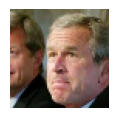

<Figure size 640x480 with 0 Axes>

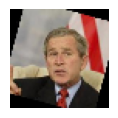

<Figure size 640x480 with 0 Axes>

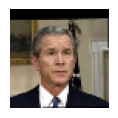

<Figure size 640x480 with 0 Axes>

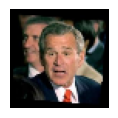

<Figure size 640x480 with 0 Axes>

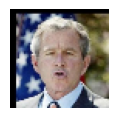

<Figure size 640x480 with 0 Axes>

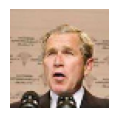

<Figure size 640x480 with 0 Axes>

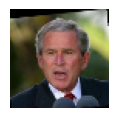

<Figure size 640x480 with 0 Axes>

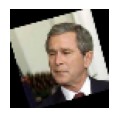

<Figure size 640x480 with 0 Axes>

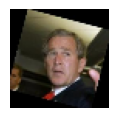

<Figure size 640x480 with 0 Axes>

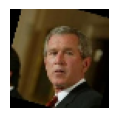

<Figure size 640x480 with 0 Axes>

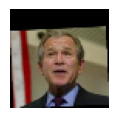

<Figure size 640x480 with 0 Axes>

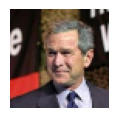

<Figure size 640x480 with 0 Axes>

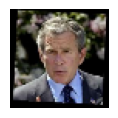

<Figure size 640x480 with 0 Axes>

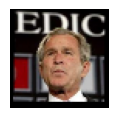

<Figure size 640x480 with 0 Axes>

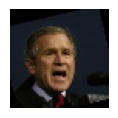

<Figure size 640x480 with 0 Axes>

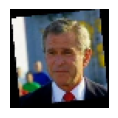

<Figure size 640x480 with 0 Axes>

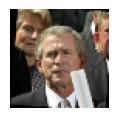

<Figure size 640x480 with 0 Axes>

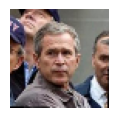

<Figure size 640x480 with 0 Axes>

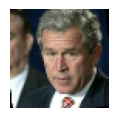

<Figure size 640x480 with 0 Axes>

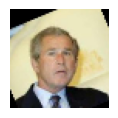

<Figure size 640x480 with 0 Axes>

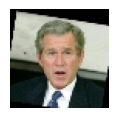

<Figure size 640x480 with 0 Axes>

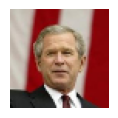

<Figure size 640x480 with 0 Axes>

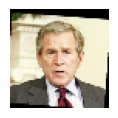

<Figure size 640x480 with 0 Axes>

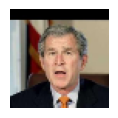

<Figure size 640x480 with 0 Axes>

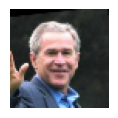

<Figure size 640x480 with 0 Axes>

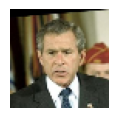

<Figure size 640x480 with 0 Axes>

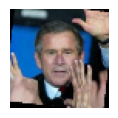

<Figure size 640x480 with 0 Axes>

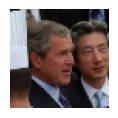

<Figure size 640x480 with 0 Axes>

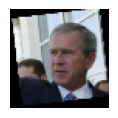

<Figure size 640x480 with 0 Axes>

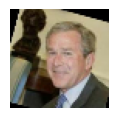

<Figure size 640x480 with 0 Axes>

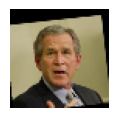

<Figure size 640x480 with 0 Axes>

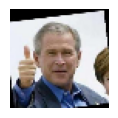

<Figure size 640x480 with 0 Axes>

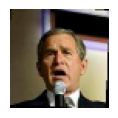

<Figure size 640x480 with 0 Axes>

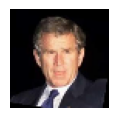

<Figure size 640x480 with 0 Axes>

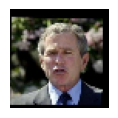

<Figure size 640x480 with 0 Axes>

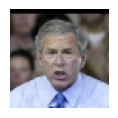

<Figure size 640x480 with 0 Axes>

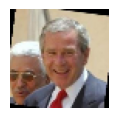

<Figure size 640x480 with 0 Axes>

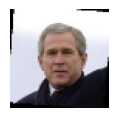

<Figure size 640x480 with 0 Axes>

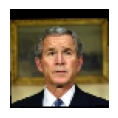

<Figure size 640x480 with 0 Axes>

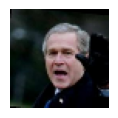

<Figure size 640x480 with 0 Axes>

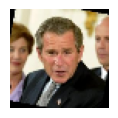

<Figure size 640x480 with 0 Axes>

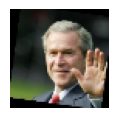

<Figure size 640x480 with 0 Axes>

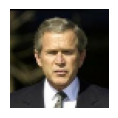

<Figure size 640x480 with 0 Axes>

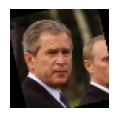

<Figure size 640x480 with 0 Axes>

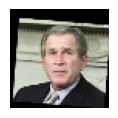

<Figure size 640x480 with 0 Axes>

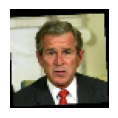

<Figure size 640x480 with 0 Axes>

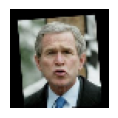

<Figure size 640x480 with 0 Axes>

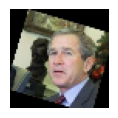

<Figure size 640x480 with 0 Axes>

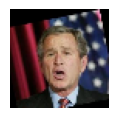

<Figure size 640x480 with 0 Axes>

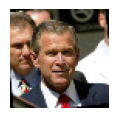

<Figure size 640x480 with 0 Axes>

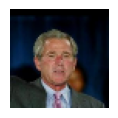

<Figure size 640x480 with 0 Axes>

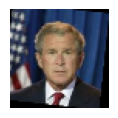

<Figure size 640x480 with 0 Axes>

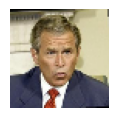

<Figure size 640x480 with 0 Axes>

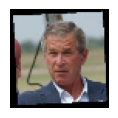

<Figure size 640x480 with 0 Axes>

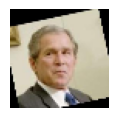

<Figure size 640x480 with 0 Axes>

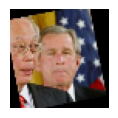

<Figure size 640x480 with 0 Axes>

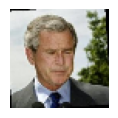

<Figure size 640x480 with 0 Axes>

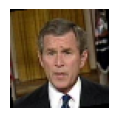

<Figure size 640x480 with 0 Axes>

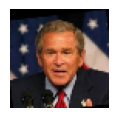

<Figure size 640x480 with 0 Axes>

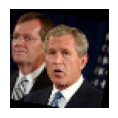

<Figure size 640x480 with 0 Axes>

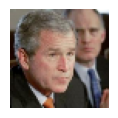

<Figure size 640x480 with 0 Axes>

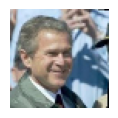

<Figure size 640x480 with 0 Axes>

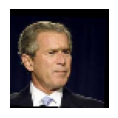

<Figure size 640x480 with 0 Axes>

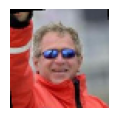

<Figure size 640x480 with 0 Axes>

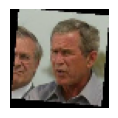

<Figure size 640x480 with 0 Axes>

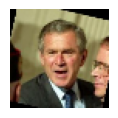

<Figure size 640x480 with 0 Axes>

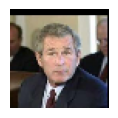

<Figure size 640x480 with 0 Axes>

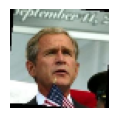

<Figure size 640x480 with 0 Axes>

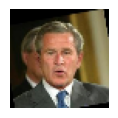

<Figure size 640x480 with 0 Axes>

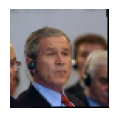

<Figure size 640x480 with 0 Axes>

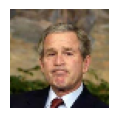

<Figure size 640x480 with 0 Axes>

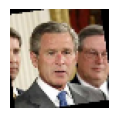

<Figure size 640x480 with 0 Axes>

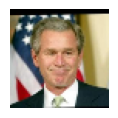

<Figure size 640x480 with 0 Axes>

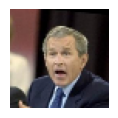

<Figure size 640x480 with 0 Axes>

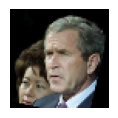

<Figure size 640x480 with 0 Axes>

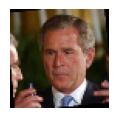

<Figure size 640x480 with 0 Axes>

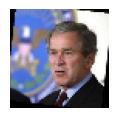

<Figure size 640x480 with 0 Axes>

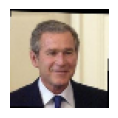

<Figure size 640x480 with 0 Axes>

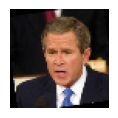

<Figure size 640x480 with 0 Axes>

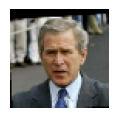

<Figure size 640x480 with 0 Axes>

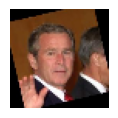

<Figure size 640x480 with 0 Axes>

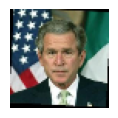

<Figure size 640x480 with 0 Axes>

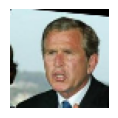

<Figure size 640x480 with 0 Axes>

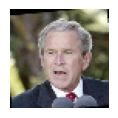

<Figure size 640x480 with 0 Axes>

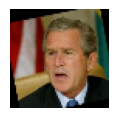

<Figure size 640x480 with 0 Axes>

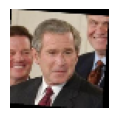

<Figure size 640x480 with 0 Axes>

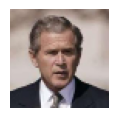

<Figure size 640x480 with 0 Axes>

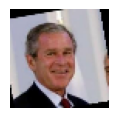

<Figure size 640x480 with 0 Axes>

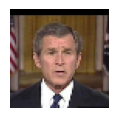

<Figure size 640x480 with 0 Axes>

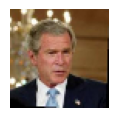

<Figure size 640x480 with 0 Axes>

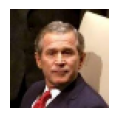

<Figure size 640x480 with 0 Axes>

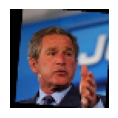

<Figure size 640x480 with 0 Axes>

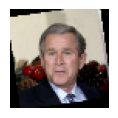

<Figure size 640x480 with 0 Axes>

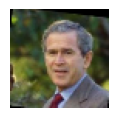

<Figure size 640x480 with 0 Axes>

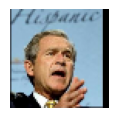

<Figure size 640x480 with 0 Axes>

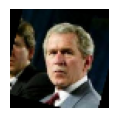

<Figure size 640x480 with 0 Axes>

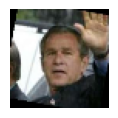

<Figure size 640x480 with 0 Axes>

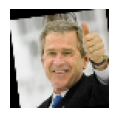

<Figure size 640x480 with 0 Axes>

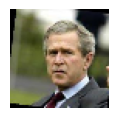

<Figure size 640x480 with 0 Axes>

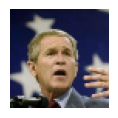

<Figure size 640x480 with 0 Axes>

In [18]:
feature_size = 8192

features = np.zeros((len(test_images), feature_size), device=device)

for idx, image in enumerate(test_images):

    feature = discriminator(np.array(image, device=device))
    feature = feature.reshape(feature_size,)
    features[idx,:] = feature.copyto(device)


for image in test_images[:100]:

    feature = discriminator(np.array(image, device=device))
    feature = feature.reshape((feature_size,))
    image   = image.reshape((3,64,64))


    indices = get_knn(features, feature, k=10)
    fig = plt.figure(figsize=(15,12))
    plt.subplot(1,10,1)

    visualize(image)
    for i in range(2,9):
        if indices[i-1][1] < 1.5:
            plt.subplot(1,10,i)
            sim = test_images[indices[i-1][0]].reshape(3,64,64)
            visualize(sim)
    plt.show()
    plt.clf()

![png](https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/doc/tutorials/info_gan/output.png)<!--notebook-skip-line-->

## How the Generator learns
We trained the Generator for a couple of epochs and stored a couple of fake images per epoch. Check the video.
                    ![infogan infogan](https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/doc/tutorials/info_gan/infogan.gif)


The following function computes the TSNE on the feature matrix and stores the result in a json-file. This file can be loaded with [TSNEViewer](https://ml4a.github.io/guides/ImageTSNEViewer/)

```{.python}
import json

from sklearn.manifold import TSNE
from scipy.spatial import distance

tsne = TSNE(n_components=2, learning_rate=150, perplexity=30, verbose=2).fit_transform(features.asnumpy())

# save data to json
data = []
counter = 0
for i,f in enumerate(test_filenames):

    point = [float((tsne[i,k] - onp.min(tsne[:,k]))/(onp.max(tsne[:,k]) - onp.min(tsne[:,k]))) for k in range(2) ]
    data.append({"path": os.path.abspath(os.path.join(os.getcwd(),f)), "point": point})

with open("imagetsne.json", 'w') as outfile:
    json.dump(data, outfile)
```


Load the file with TSNEViewer. You can now inspect whether similiar looking images are grouped nearby or not.

<img src="https://raw.githubusercontent.com/NRauschmayr/web-data/master/mxnet/doc/tutorials/info_gan/tsne.png" style="width:800px;height:600px;">

<!-- INSERT SOURCE DOWNLOAD BUTTONS -->